In [29]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import os

from typing import Tuple, Any
import numpy.typing as npt

plt.style.use(['science', 'ieee', 'no-latex'])

In [30]:
NA = 0.86
LAMBDA = 248
K = 2 * np.pi / LAMBDA
W = NA / LAMBDA
THRESHOLD = 0.5

# target_path = './img_test/sources_1D/'
# if not os.path.isdir(target_path):
#     os.makedirs(target_path)

In [31]:
# sampling rate
Fs_single = 1000
# single slit space
s_single_space = 1000
s_single_width = 100
s_single = np.linspace(
    -s_single_space, s_single_space,
    2 * s_single_space * Fs_single + 1,
    dtype=np.double
)
# single slit mask
s_single_mask = np.where(np.abs(s_single) <= s_single_width, 1, 0)

In [32]:
def generate_Ein(
    s: npt.NDArray[Any],
    sin_value: np.double,
    magnitude: int = 1
) -> npt.NDArray:
    return magnitude * np.exp(1j * K * s * sin_value)

In [33]:
def freq_and_Eoutshift(
    s: npt.NDArray[Any],
    E_out_unshift: npt.NDArray[Any],
    Fs: int
) -> Tuple[npt.NDArray[Any], npt.NDArray[Any]]:
    N = (s.shape[0] - 1) // 2
    freq = Fs * np.arange(-N, N + 1) / (2 * N)
    E_out_shift = np.concatenate((E_out_unshift[N + 1:], E_out_unshift[:N + 1]))
    return freq, E_out_shift

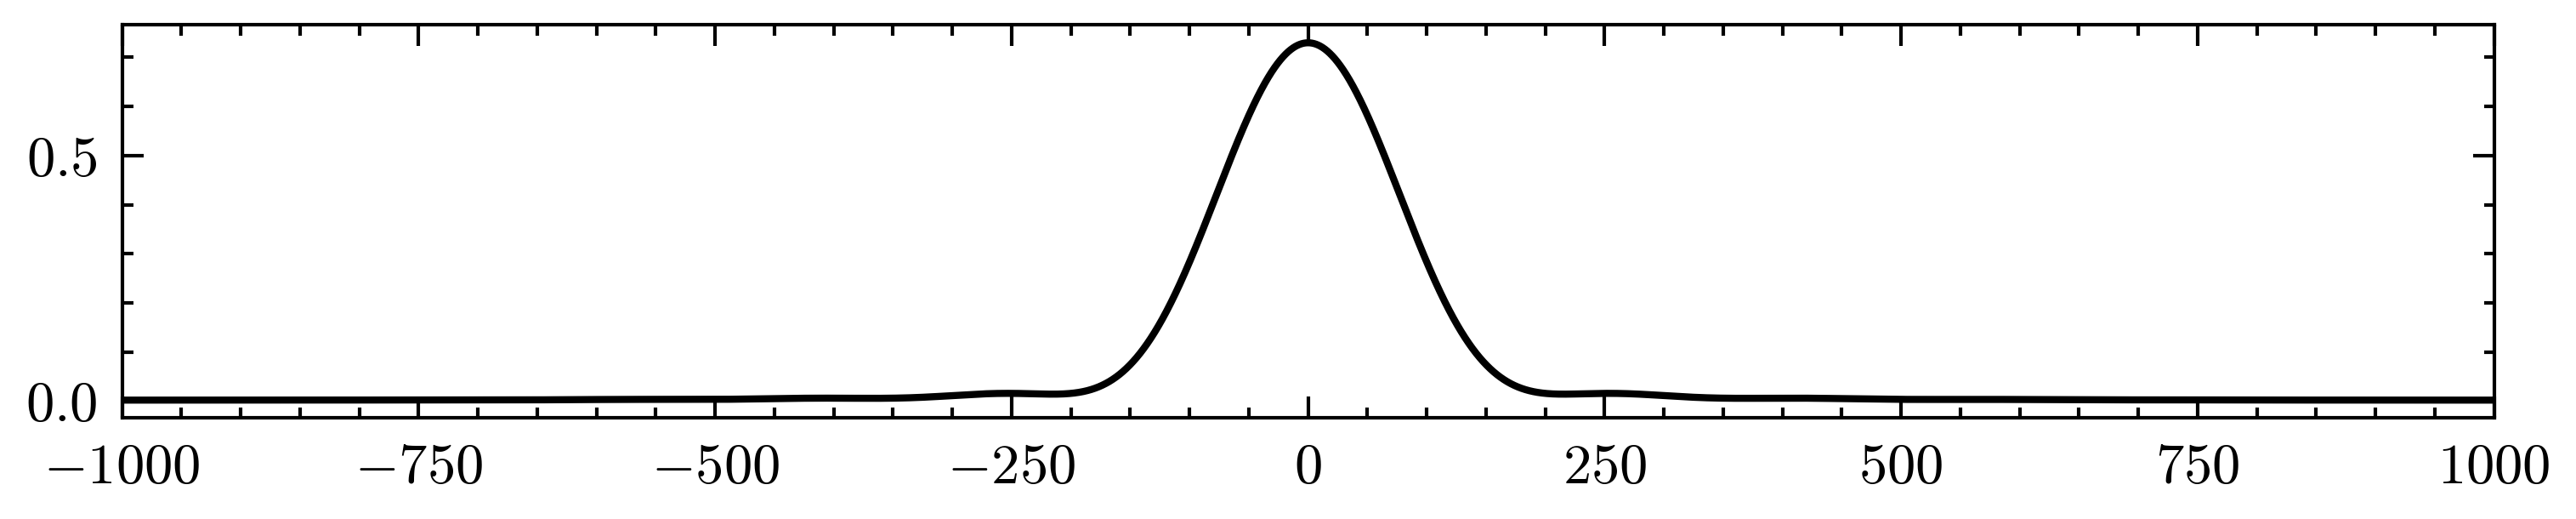

In [34]:
# divided NA (sin theta) into several sources
n_sources = 100
s_sources_sin_values = np.linspace(-NA, NA, n_sources + 1, dtype=np.double)
# generate Ein with different angle
magnitude = 1
I = np.zeros_like(s_single)
for sin_value in s_sources_sin_values:
    # generate Ein with angle
    E_in = generate_Ein(s_single, sin_value, magnitude)
    # Ein and the mask
    E_in_mask = np.multiply(E_in, s_single_mask)
    # generate E_out
    E_out_unshift = np.fft.fft(E_in_mask)
    # get freq, Eout
    freq, E_out_shift = freq_and_Eoutshift(
        s_single, E_out_unshift, Fs_single
    )
    # condition specified frequency region
    cond = np.abs(freq) <= 0.1
    # after exit pupil
    E_out_shift_after_exit_pupil = np.where(
        np.abs(freq) <= W, E_out_shift, 0
    )
    # aerial image
    _, E_out_unshift_after_exit_pupil = freq_and_Eoutshift(
        s_single, E_out_shift_after_exit_pupil, Fs_single
    )
    E_output = np.fft.ifft(E_out_unshift_after_exit_pupil)
    I += np.multiply(np.abs(E_output), np.abs(E_output))
    

I = I / (n_sources + 1)
plt.figure(figsize=(6, 1))
plt.xlim(-s_single_space, s_single_space)	
plt.plot(s_single, I, '-')
plt.savefig(f'{target_path}/n_sources_equal_aerial_image.png')

In [35]:
try:
    freq_left = np.min(s_single[I >= THRESHOLD])
    freq_right = np.max(s_single[I >= THRESHOLD])
    CD = freq_right - freq_left
# if not
except ValueError:
    CD = 0
CD

np.float64(128.59400000000005)